In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet
from networks.Inception_Resnet_V1_Fuzzy import Inception_Resnet_V1_Fuzzy
# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

In [2]:
def load_data(file_name):
    attack_image = np.loadtxt(file_name+"_attack_image.csv", delimiter=",")
    attack_free_image = np.loadtxt(file_name+"_attack_free_image.csv", delimiter=",")
    attack_image_seq = np.loadtxt(file_name+"_attack_image_seq.csv", delimiter=',')
    attakc_free_image_seq = np.loadtxt(file_name+"_attack_free_image_seq.csv", 
                                       delimiter=',')
    attack_image = attack_image.reshape(
        attack_image.shape[0], 29, 29, 1
    )
    attack_free_image = attack_free_image.reshape(
        attack_free_image.shape[0], 29, 29, 1
    )
    attack_y = np.array([[1]] * attack_image.shape[0])
    attack_free_y = np.array([[0]] * attack_free_image.shape[0])
    
    return (attack_image, attack_y, attack_free_image, attack_free_y, attack_image_seq) 
#     x_data = np.concatenate((attack_image, attack_free_image))
#     x_data_seq = np.concatenate((attakc_image_seq, attakc_free_image_seq))
#     y_data = np.concatenate((attack_y, attack_free_y))

#     train_x = x_data[:int(x_data.shape[0] * 0.7)]
#     test_x = x_data[int(x_data.shape[0] * 0.7):]
#     train_x_seq = x_data_seq[:int(x_data.shape[0] * 0.7)]
#     test_x_seq = x_data_seq[int(x_data.shape[0] * 0.7):]
#     train_y = y_data[:int(x_data.shape[0] * 0.7)]
#     test_y = y_data[int(x_data.shape[0] * 0.7):]

#     return (train_x, train_y), (test_x, test_y), (train_x_seq, test_x_seq)

In [3]:
# (x_train, y_train), (x_test, y_test), (x_train_seq, x_test_seq) = load_data("./CAN_DATA/DoS")
(attack_image, attack_y, attack_free_image, attack_free_y, attack_image_seq) = load_data("./CAN_DATA/Fuzzy")

In [4]:
class_names = ['normal', 'attack']
print(len(attack_image))
print(len(attack_free_image))

44486
87888


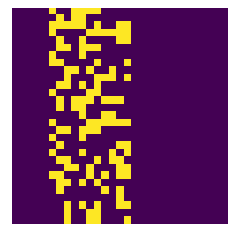

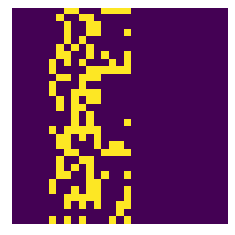

In [5]:
image_id = 600
helper.plot_image(attack_image[image_id])
helper.plot_image(attack_free_image[image_id])



In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 3)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs
    

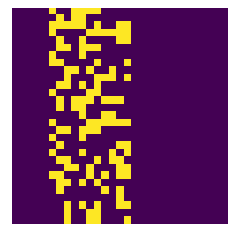

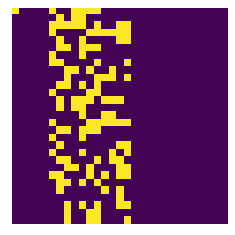

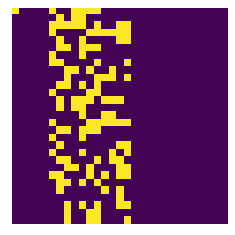

In [7]:
imgae_id = 100
pixel = np.array([[0.82811573, 0.12493119, 1.5], [0, 0, 1]])
image_perturbed = perturb_image(pixel, attack_image[image_id])[0]
image_perturbed_1 = perturb_image(pixel, attack_image[image_id])[1]
helper.plot_image(attack_image[image_id])
helper.plot_image(image_perturbed)
helper.plot_image(image_perturbed_1)

In [8]:
Inception_Resnet_V1_Fuzzy = Inception_Resnet_V1_Fuzzy()
models = [Inception_Resnet_V1_Fuzzy]

Successfully loaded Inception_Resnet_V1_Fuzzy


In [9]:
network_stats, correct_imgs = helper.evaluate_models(models,attack_image, attack_y)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating Inception_Resnet_V1_Fuzzy


,name,accuracy,param_count
0,Inception_Resnet_V1_Fuzzy,0.964034,1691490


In [10]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [11]:
def predict_1(img, model):
    img_reshape = img.reshape([1, 29, 29, 1])
    prior_confidence = model.predict_one(img_reshape)
    return prior_confidence

Confidence in true class attack is 0.99999774
Prior confidence was 0.9999926


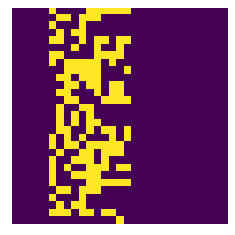

In [37]:
image_id = 500
pixel = np.array([16, 13, 1])
model = Inception_Resnet_V1_Fuzzy

true_class = attack_y[image_id, 0]
prior_confidence = predict_1(attack_image[image_id], model)[true_class]
confidence = predict_classes(pixel, attack_image[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, attack_image[image_id])[0])

In [14]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Confidence: 0.9026198
Prior confidence [0.0049871 0.9950128]
Attack success: False


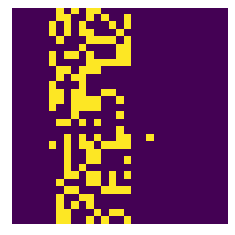

In [16]:
image_id = 541
pixel = np.array([17, 18, 1])
model = Inception_Resnet_V1_Fuzzy
true_class = attack_y[image_id, 0]
prior_confidence = predict_1(attack_image[image_id], model)
success = attack_success(pixel, attack_image[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, attack_image[image_id])[0])

In [35]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else attack_y[img_id, 0]
    test_seq = attack_image_seq[img_id]
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = []
    for i in range(0, len(test_seq)):
        if test_seq[i] == 0:
            continue
        else:
            bound = [(i, i+1), (0, 29), (1, 2)] * pixel_count
            
            bounds = bounds + bound
   

    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, attack_image[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, attack_image[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
    #print(attack_result.x)
    # Calculate some useful statistics to return from this function
    attack_image_ = perturb_image(attack_result.x, attack_image[img_id])[0]
    true_class = attack_y[image_id, 0]
    prior_probs = predict_1(attack_image[img_id], model)
    predicted_probs = predict_1(attack_image_, model)

    
    predicted_class = np.argmax(predicted_probs)
    #print(predicted_class)
    actual_class = attack_y[img_id, 0]
    #print(actual_class)
    success = predicted_class != actual_class
    #cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image_, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, prior_probs, predicted_probs, attack_result.x]

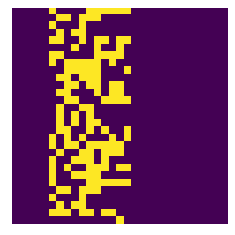

Confidence: 0.90629053
Confidence: 0.8779634
Confidence: 0.8779634
Confidence: 0.8551063
Confidence: 0.8551063
Confidence: 0.8551063
Confidence: 0.8535741
Confidence: 0.8535741
Confidence: 0.81844974
Confidence: 0.81844974
Confidence: 0.81844974
Confidence: 0.81844974
Confidence: 0.8148022
Confidence: 0.8148022
Confidence: 0.8148022
Confidence: 0.8148022
Confidence: 0.73569775
Confidence: 0.73569775
Confidence: 0.73569775
Confidence: 0.73569775
Confidence: 0.73382646
Confidence: 0.73382646
Confidence: 0.73382646
Confidence: 0.73382646
Confidence: 0.5882189
Confidence: 0.5882189
Confidence: 0.5882189
Confidence: 0.5882189
Confidence: 0.5882189
Confidence: 0.5882189
Confidence: 0.5376169
Confidence: 0.3913167


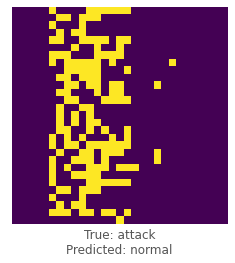

In [38]:
image_id = 500
pixels = 1 # Number of pixels to attack
model = Inception_Resnet_V1_Fuzzy
helper.plot_image(attack_image[image_id])
_ = attack(image_id, model, pixel_count=pixels, verbose=True)

In [29]:
def attack_all(model, pixels = 1, targeted = False,
              maxiter = 75, popsize = 400, verbose = False):
    
    
    success_results = []
    fail_results = []
    total_length = len(attack_image)
    for img_id, img in enumerate(attack_image):
        result = attack(img_id, model, target = None, pixel_count = pixels,
                       maxiter = maxiter, popsize = popsize, verbose = verbose)
        if result[5] == True:
            success_results.append(result)
        else:
            fail_results.append(result)
        
        if img_id % 100 == 0:
            print("진행률 : ",img_id,"/",total_length)
            print("현재 탐지 율 : ", (len(fail_results)) / (len(success_results) + len(fail_results)))
    
        
    return success_results, fail_results
        

In [32]:
success_results, fail_results = attack_all(model)
detection_rate = (len(fail_results) / (len(success_results) + len(fail_results)))

print("detection_rate : ", detection_rate)

진행률 :  0 / 44486
현재 탐지 율 :  0.0
진행률 :  100 / 44486
현재 탐지 율 :  0.21782178217821782
진행률 :  200 / 44486
현재 탐지 율 :  0.22885572139303484
진행률 :  300 / 44486
현재 탐지 율 :  0.1760797342192691
진행률 :  400 / 44486
현재 탐지 율 :  0.1546134663341646
진행률 :  500 / 44486
현재 탐지 율 :  0.1317365269461078
진행률 :  600 / 44486
현재 탐지 율 :  0.11480865224625623
진행률 :  700 / 44486
현재 탐지 율 :  0.10413694721825963
진행률 :  800 / 44486
현재 탐지 율 :  0.09987515605493133
진행률 :  900 / 44486
현재 탐지 율 :  0.09655937846836848
진행률 :  1000 / 44486
현재 탐지 율 :  0.10989010989010989
진행률 :  1100 / 44486
현재 탐지 율 :  0.1226158038147139
진행률 :  1200 / 44486
현재 탐지 율 :  0.12489592006661115
진행률 :  1300 / 44486
현재 탐지 율 :  0.12375096079938509
진행률 :  1400 / 44486
현재 탐지 율 :  0.12633832976445397
진행률 :  1500 / 44486
현재 탐지 율 :  0.12591605596269154
진행률 :  1600 / 44486
현재 탐지 율 :  0.1267957526545909
진행률 :  1700 / 44486
현재 탐지 율 :  0.12463256907701352
진행률 :  1800 / 44486
현재 탐지 율 :  0.11937812326485286
진행률 :  1900 / 44486
현재 탐지 율 :  0.11730668069437139
진행률 :  2000 /

C:\Users\jeongseok\one-pixel-attack-keras-master\differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


진행률 :  3400 / 44486
현재 탐지 율 :  0.11290796824463394
진행률 :  3500 / 44486
현재 탐지 율 :  0.112539274493002
진행률 :  3600 / 44486
현재 탐지 율 :  0.11274645931685642
진행률 :  3700 / 44486
현재 탐지 율 :  0.11240205349905431
진행률 :  3800 / 44486
현재 탐지 율 :  0.1126019468560905
진행률 :  3900 / 44486
현재 탐지 율 :  0.11279159189951295
진행률 :  4000 / 44486
현재 탐지 율 :  0.11147213196700825
진행률 :  4100 / 44486
현재 탐지 율 :  0.11070470616922702
진행률 :  4200 / 44486
현재 탐지 율 :  0.11259223994287075
진행률 :  4300 / 44486
현재 탐지 율 :  0.11253196930946291
진행률 :  4400 / 44486
현재 탐지 율 :  0.11042944785276074
진행률 :  4500 / 44486
현재 탐지 율 :  0.10908686958453677
진행률 :  4600 / 44486
현재 탐지 율 :  0.10845468376439904
진행률 :  4700 / 44486
현재 탐지 율 :  0.10891299723463092
진행률 :  4800 / 44486
현재 탐지 율 :  0.10893563840866487
진행률 :  4900 / 44486
현재 탐지 율 :  0.10732503570699857
진행률 :  5000 / 44486
현재 탐지 율 :  0.10657868426314737
진행률 :  5100 / 44486
현재 탐지 율 :  0.10625367574985296
진행률 :  5200 / 44486
현재 탐지 율 :  0.10594116516054605
진행률 :  5300 / 44486
현재 탐지 율 :  0.1

진행률 :  19400 / 44486
현재 탐지 율 :  0.10087108911911757
진행률 :  19500 / 44486
현재 탐지 율 :  0.10122557817547818
진행률 :  19600 / 44486
현재 탐지 율 :  0.10142339676547114
진행률 :  19700 / 44486
현재 탐지 율 :  0.10131465407847318
진행률 :  19800 / 44486
현재 탐지 율 :  0.1014595222463512
진행률 :  19900 / 44486
현재 탐지 율 :  0.10165318325712276
진행률 :  20000 / 44486
현재 탐지 율 :  0.10209489525523724
진행률 :  20100 / 44486
현재 탐지 율 :  0.10183572956569326
진행률 :  20200 / 44486
현재 탐지 율 :  0.1017276372456809
진행률 :  20300 / 44486
현재 탐지 율 :  0.10157135116496724
진행률 :  20400 / 44486
현재 탐지 율 :  0.10195578648105486
진행률 :  20500 / 44486
현재 탐지 율 :  0.101702355982635
진행률 :  20600 / 44486
현재 탐지 율 :  0.1016940925197806
진행률 :  20700 / 44486
현재 탐지 율 :  0.10216897734408965
진행률 :  20800 / 44486
현재 탐지 율 :  0.10191817701072065
진행률 :  20900 / 44486
현재 탐지 율 :  0.10186115496866179
진행률 :  21000 / 44486
현재 탐지 율 :  0.10180467596781105
진행률 :  21100 / 44486
현재 탐지 율 :  0.10203307900099522
진행률 :  21200 / 44486
현재 탐지 율 :  0.10192915428517522
진행률 :  21300 / 44

진행률 :  35200 / 44486
현재 탐지 율 :  0.11590579813073493
진행률 :  35300 / 44486
현재 탐지 율 :  0.11597405172657999
진행률 :  35400 / 44486
현재 탐지 율 :  0.11607016750939239
진행률 :  35500 / 44486
현재 탐지 율 :  0.11608123714824935
진행률 :  35600 / 44486
현재 탐지 율 :  0.11623269009297492
진행률 :  35700 / 44486
현재 탐지 율 :  0.11641130500546203
진행률 :  35800 / 44486
현재 탐지 율 :  0.11672858300047485
진행률 :  35900 / 44486
현재 탐지 율 :  0.11698838472465949
진행률 :  36000 / 44486
현재 탐지 율 :  0.11744118218938362
진행률 :  36100 / 44486
현재 탐지 율 :  0.11753137032215175
진행률 :  36200 / 44486
현재 탐지 율 :  0.11770393083064004
진행률 :  36300 / 44486
현재 탐지 율 :  0.11760006611388116
진행률 :  36400 / 44486
현재 탐지 율 :  0.11766160270322244
진행률 :  36500 / 44486
현재 탐지 율 :  0.11780499164406455
진행률 :  36600 / 44486
현재 탐지 율 :  0.11786563208655501
진행률 :  36700 / 44486
현재 탐지 율 :  0.11770796436064412
진행률 :  36800 / 44486
현재 탐지 율 :  0.11752398032662156
진행률 :  36900 / 44486
현재 탐지 율 :  0.11739519254220752
진행률 :  37000 / 44486
현재 탐지 율 :  0.11756439015161753
진행률 :  37100